In [64]:
import json
import sys
from requests import Session, Request
from datetime import datetime, date, time, timedelta, timezone
from posixpath import join as urljoin
import pandas as pd
import io
from blume import client, station, measurements
from blume.station import Station
from sensemapi import client as sense_client
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import pytz
cet = pytz.timezone('CET')



# set the graphs to show in the jupyter notebook
%matplotlib inline

# set seaborn style to white
sns.set_style("white")

## Load Data from BLUME into Pandas Datafram
- Load the newest Data from the Website
- Archive into local Data Storage
- Read all new and old Measurments from Data Storage
- Create Global Matrix (Time x Station = Measuremt)

In [67]:
#Scrape newest/available data from the Blume-Website
df = client.get_blume_measurments()
df = client.clean_data(df)

#Create Measurements and append to local storage of data (JSON)
online_measurement = client.create_measurements(df)

#Initially load all Stations from local storage (JSON)
station.init_stations()
#Source all available Information from local storage to pandas df
station_collection = Station.station_collection

#get all available station ids and use them to get all measurements from all
# stations
station_ids = [station.id for station in station_collection]
all_station_measurements = measurements.read_measurements_by_station_id_list(
    station_ids)

#from all measurements, get pandas series and combine to global matrix
df_local = [m.dataframe for m in all_station_measurements]
df_global = pd.concat(df_local, axis=1)

#Make Timezone aware and convert everything to UTC (API-Language)
df_global = df_global.tz_localize("CET")


df_global.tail(10)

,10,32,42,77,85,88,117,124,143,171,174,220
2020-01-19 00:00:00+01:00,14,14.0,16,16,13,16,16.0,18,24,15.0,19.0,19
2020-01-19 01:00:00+01:00,16,15.0,17,17,14,18,17.0,19,25,17.0,21.0,19
2020-01-19 02:00:00+01:00,18,17.0,18,18,15,18,19.0,20,25,17.0,21.0,20
2020-01-19 03:00:00+01:00,18,18.0,19,19,15,19,20.0,21,23,18.0,21.0,20
2020-01-19 04:00:00+01:00,20,19.0,20,19,16,21,21.0,21,25,20.0,22.0,21
2020-01-19 05:00:00+01:00,20,18.0,19,20,18,20,20.0,21,24,20.0,23.0,21
2020-01-19 06:00:00+01:00,17,17.0,17,20,19,18,19.0,20,21,17.0,22.0,20
2020-01-19 07:00:00+01:00,18,17.0,17,20,16,18,19.0,19,21,17.0,22.0,18
2020-01-19 08:00:00+01:00,18,17.0,17,20,16,18,20.0,20,24,18.0,22.0,19
2020-01-19 09:00:00+01:00,18,17.0,17,20,18,18,21.0,21,24,19.0,22.0,19


In [68]:
df_global.index

DatetimeIndex(['2019-11-22 13:00:00+01:00', '2019-11-22 14:00:00+01:00',
               '2019-11-22 15:00:00+01:00', '2019-11-22 16:00:00+01:00',
               '2019-11-22 17:00:00+01:00', '2019-11-22 18:00:00+01:00',
               '2019-11-22 19:00:00+01:00', '2019-11-22 20:00:00+01:00',
               '2019-11-22 21:00:00+01:00', '2019-11-22 22:00:00+01:00',
               ...
               '2020-01-19 00:00:00+01:00', '2020-01-19 01:00:00+01:00',
               '2020-01-19 02:00:00+01:00', '2020-01-19 03:00:00+01:00',
               '2020-01-19 04:00:00+01:00', '2020-01-19 05:00:00+01:00',
               '2020-01-19 06:00:00+01:00', '2020-01-19 07:00:00+01:00',
               '2020-01-19 08:00:00+01:00', '2020-01-19 09:00:00+01:00'],
              dtype='datetime64[ns, CET]', length=1389, freq=None)

# Test 1: Compare Hourly mean for all of Berlin at a specific Hour
First, define statistical Variables
Be careful with BLUME Dates: When you ask for 14:00, it means you receive the mean from 13:00-14:00.

In [70]:
#SenseMapi related
example_to_date = pd.Timestamp(2019, 11, 30, 12, 0, 0, 0)
example_to_date = pd.Timestamp(example_to_date,  tz='CET')
example_from_date = example_to_date - timedelta(hours=1)
bbox_berlin = [13.0883, 52.3383, 13.7612, 52.6755]

## Load all PM10 Values from Berlin (OSeM) into DataFrame
- Create Request according to Statistical Parameters
- From all Sensors, Flatten the 
- Convert everything to Pandas Dataframe

In [72]:
senseMapiresponse = sense_client.SenseMapClient().get_measurements_by_phenomenon(
    bbox=bbox_berlin,
    phenomenon="PM10",
    from_date=example_from_date,
    to_date=example_to_date)

# Load all PM10 Values from Berlin (OSeM) into DataFrame
sensor_vals_df = [i.series for i in senseMapiresponse]
final_df = pd.concat(sensor_vals_df, axis=1)
#Response comes in UTC, convert back to CET
final_df = final_df.tz_localize("UTC")
final_df = final_df.tz_convert("CET")

In [73]:
final_df

,590b8480dd09cc0011aa79cd_PM10,591ecdc251d3460011651ffa_PM10,592ca4b851d3460011ea2636_PM10,593458ddad0fa30011ea0962_PM10,5936c52aad0fa30011033d68_PM10,594c01c7be77820011792181_PM10,5984c712e3b1fa001069150d_PM10,5998a7bad67eb500114b7d7b_PM10,599f3364d67eb50011b85cd4_PM10,59b9030bd67eb500117a3ff2_PM10,...,5d78d78f953683001a412c22_PM10,5d8a549d5f3de0001a7c3509_PM10,5d9ef41e25683a001ad916c7_PM10,5d9f216425683a001ae684cf_PM10,5da0a27f25683a001a59271d_PM10,5da202ac25683a001ac232e9_PM10,5dbf1a8ca68df4001adead33_PM10,5dc5d2d37d4ff7001ac78624_PM10,5dcbe2d1306947001a2c353f_PM10,5dd810224ec04e001a2212a3_PM10
2019-11-30 11:00:08.529000+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-30 11:00:10.882000+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-30 11:00:11.860000+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-30 11:00:18+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-30 11:00:18.547000+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-30 11:59:55.257000+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-30 11:59:55.261000+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-30 11:59:57.751000+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-30 11:59:58.898000+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
final_df.describe()

,590b8480dd09cc0011aa79cd_PM10,591ecdc251d3460011651ffa_PM10,592ca4b851d3460011ea2636_PM10,593458ddad0fa30011ea0962_PM10,5936c52aad0fa30011033d68_PM10,594c01c7be77820011792181_PM10,5984c712e3b1fa001069150d_PM10,5998a7bad67eb500114b7d7b_PM10,599f3364d67eb50011b85cd4_PM10,59b9030bd67eb500117a3ff2_PM10,...,5d78d78f953683001a412c22_PM10,5d8a549d5f3de0001a7c3509_PM10,5d9ef41e25683a001ad916c7_PM10,5d9f216425683a001ae684cf_PM10,5da0a27f25683a001a59271d_PM10,5da202ac25683a001ac232e9_PM10,5dbf1a8ca68df4001adead33_PM10,5dc5d2d37d4ff7001ac78624_PM10,5dcbe2d1306947001a2c353f_PM10,5dd810224ec04e001a2212a3_PM10
count,23.000000,24.000000,23.000000,23.000000,12.000000,23.000000,24.000000,24.000000,57.000000,23.000000,...,10.000000,23.000000,24.000000,53.000000,4.000000,11.000000,23.000000,24.000000,23.000000,21.000000
mean,19.437391,23.472083,1.813478,5.350000,10.738333,9.293478,24.571667,14.976667,30.254211,7.297826,...,14.379000,24.690435,22.725833,15.424151,23.550000,15.749091,10.267826,17.506667,19.283043,19.263333
std,16.044018,4.572607,0.649941,1.687039,1.561921,2.659926,6.969347,3.024002,25.608425,0.433579,...,5.985582,6.199901,3.547336,2.367984,2.937686,4.508269,2.135435,3.406627,3.037295,2.579177
min,10.130000,14.900000,1.230000,3.970000,8.730000,5.230000,14.270000,10.270000,17.150000,6.730000,...,8.370000,16.370000,18.170000,10.800000,20.600000,8.900000,6.450000,11.100000,13.850000,14.150000
25%,13.750000,21.055000,1.350000,4.270000,9.777500,7.880000,20.342500,12.602500,23.420000,7.015000,...,10.862500,19.920000,20.517500,13.630000,22.175001,13.185000,9.090000,15.422500,17.600000,17.330000
50%,16.020000,23.950000,1.500000,4.700000,10.085000,8.630000,23.100000,14.415000,26.200000,7.100000,...,13.515000,23.870000,22.150000,15.800000,23.000000,13.930000,9.650000,17.520000,18.980000,19.730000
75%,18.625000,26.772500,2.070000,5.885000,12.297500,9.765000,28.335000,16.740000,29.230000,7.450000,...,15.755000,27.025000,23.417500,17.120000,24.374999,19.435000,11.660000,19.702500,21.025000,20.750000
max,91.350000,31.430000,3.630000,11.430000,12.930000,16.300000,45.600000,21.300000,214.400000,8.570000,...,29.100000,40.450000,30.800000,20.730000,27.600000,23.470000,14.650000,24.200000,25.980000,23.700000


Create the Same Mask for Blume

In [76]:
#BLUME related
example_mean = df_global.loc[example_to_date]
example_mean

10     16.0
32     13.0
42     16.0
77     17.0
85     19.0
88     17.0
117    15.0
124    21.0
143    19.0
171    16.0
174    23.0
220    22.0
Name: 2019-11-30 12:00:00+01:00, dtype: float64

## Results

In [79]:
print("Gesamt Berliner Feinstaubmittelwert am {} von {} bis {} Uhr"
    .format(
    example_from_date.strftime('%d.%m.%Y'),
    example_from_date.strftime('%H'),
    example_to_date.strftime('%H')
    )
)
print("Umweltbundesamt\t= {}"
    .format(example_mean.mean())
)
print("OpenSenseMap\t= {}"
    .format(final_df.mean().mean())
)

Gesamt Berliner Feinstaubmittelwert am 30.11.2019 von 11 bis 12 Uhr
Umweltbundesamt	= 17.833333333333332
OpenSenseMap	= 13.172582795539995


# Test 2: Compare Hourly mean for all of Berlin for 24 Hours
Same as Test 1, but now for the whole day, to see if there is a time where the relation is good / bad

In [80]:
#SenseMapi related
example_to_date = pd.Timestamp(2019, 12, 12, 0, 0, 0, 0)
example_to_date = pd.Timestamp(example_to_date,  tz='CET')
example_from_date = example_to_date - timedelta(hours=24)
#BLUME related: Careful adjuste the dates! BLUME publishes the hourly mean for 13:00 - 14:00 as 14:00
blume_start_date = example_from_date + timedelta(hours=1)
blume_end_date = example_to_date

# Load from BLUME and create DataFrame
- Load the Data for the specified 24h
- Create Dataframe with the mean of every hour

In [85]:
mask = (df_global.index >= blume_start_date) & (df_global.index <= blume_end_date)
blume_hourly = df_global.loc[mask]
blume_hourly

,10,32,42,77,85,88,117,124,143,171,174,220
2019-12-11 01:00:00+01:00,17,14.0,15,19,13,17,18.0,17,20,18.0,23.0,16
2019-12-11 02:00:00+01:00,16,14.0,15,18,12,17,18.0,15,18,18.0,22.0,15
2019-12-11 03:00:00+01:00,15,13.0,13,16,11,15,16.0,14,17,16.0,19.0,14
2019-12-11 04:00:00+01:00,12,12.0,11,14,9,13,14.0,13,15,14.0,16.0,12
2019-12-11 05:00:00+01:00,11,10.0,10,13,7,12,12.0,12,14,12.0,15.0,11
2019-12-11 06:00:00+01:00,10,10.0,9,13,8,14,12.0,14,14,11.0,15.0,11
2019-12-11 07:00:00+01:00,11,9.0,10,13,9,18,14.0,18,20,11.0,17.0,13
2019-12-11 08:00:00+01:00,12,9.0,11,14,9,16,16.0,18,26,12.0,20.0,14
2019-12-11 09:00:00+01:00,14,10.0,12,16,10,18,17.0,20,23,15.0,30.0,29
2019-12-11 10:00:00+01:00,14,10.0,13,18,9,18,18.0,21,25,14.0,29.0,20


## Load all PM10 Values from Berlin (OSeM) into DataFrame
Same like above, but with much larger Dataset (Response Time might be longer).

In [86]:
senseMapiresponse = sense_client.SenseMapClient().get_measurements_by_phenomenon(
    bbox=bbox_berlin,
    phenomenon="PM10",
    from_date=example_from_date,
    to_date=example_to_date)

# Load all PM10 Values from Berlin (OSeM) into DataFrame
sensor_vals_df = [i.series for i in senseMapiresponse]
final_df = pd.concat(sensor_vals_df, axis=1)
#Response comes in UTC, convert back to CET
final_df = final_df.tz_localize("UTC")
final_df = final_df.tz_convert("CET")

Generate the Hourly-Mean for the given 24h interval of all Sensors in Berlin

In [90]:
#Using right label because BLUME does the same... Be careful, don't mix up the periods
hourly_sensors = final_df.resample('60T', label='right').mean()
hourly_sensors.head()

,591ecdc251d3460011651ffa_PM10,592ca4b851d3460011ea2636_PM10,593458ddad0fa30011ea0962_PM10,5936c52aad0fa30011033d68_PM10,594c01c7be77820011792181_PM10,595178fb94f0520011e083ed_PM10,5984c712e3b1fa001069150d_PM10,5998a7bad67eb500114b7d7b_PM10,599f3364d67eb50011b85cd4_PM10,59b9030bd67eb500117a3ff2_PM10,...,5d8a549d5f3de0001a7c3509_PM10,5d9ef41e25683a001ad916c7_PM10,5d9f216425683a001ae684cf_PM10,5da0a27f25683a001a59271d_PM10,5da202ac25683a001ac232e9_PM10,5dbf1a8ca68df4001adead33_PM10,5dc5d2d37d4ff7001ac78624_PM10,5dcbe2d1306947001a2c353f_PM10,5dd810224ec04e001a2212a3_PM10,5ded15e22b3516001a35dad2_PM10
2019-12-11 01:00:00+01:00,20.689565,9.900000,NaN,14.444167,17.247500,18.999167,24.155000,19.642500,20.457636,7.216957,...,19.696250,NaN,18.009630,28.750000,15.570000,17.037500,16.954348,28.263478,21.098261,138.020000
2019-12-11 02:00:00+01:00,19.544583,11.552917,NaN,15.643333,17.359091,19.325000,24.452083,19.963750,20.132909,7.132174,...,18.967917,NaN,17.920727,26.425001,16.191667,18.063636,17.977273,29.086957,21.480000,131.409130
2019-12-11 03:00:00+01:00,20.674783,11.908261,NaN,15.837500,16.292609,18.957826,23.498750,16.518333,18.647925,6.781250,...,19.482917,NaN,16.536182,24.299999,12.163636,16.025652,15.672174,27.661304,20.309583,108.567083
2019-12-11 04:00:00+01:00,16.204583,10.213478,NaN,8.932500,12.335217,15.267500,18.443333,14.825833,14.683818,6.935652,...,15.732500,NaN,15.540741,20.550000,14.033333,16.262083,12.452083,22.073043,15.611818,88.941667
2019-12-11 05:00:00+01:00,14.102917,8.425000,NaN,8.863636,9.632500,11.722273,14.563913,12.618182,12.400714,6.684583,...,13.856667,NaN,13.780556,16.075000,9.650000,12.705652,12.473750,18.954783,14.103043,74.079583


For every Hour, get the mean value of all sensor in Berlin in the specified 24h period - both for osem and for blume

In [114]:
hourly_sensor_mean = hourly_sensors.mean(axis=1)
hourly_sensor_mean.name="OSeM"
hourly_blume_mean = blume_hourly.mean(axis=1)
hourly_blume_mean.name="BLUME"

Now Append the hourly means from BLUME and append as a second colum to the data-set

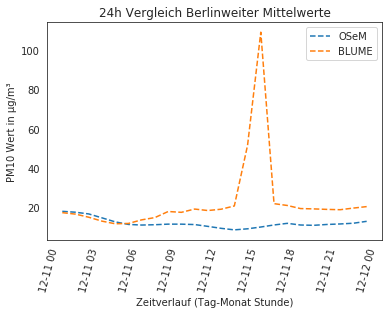

In [137]:
plt.plot_date(hourly_sensor_mean.index, hourly_sensor_mean, fmt="--", label="OSeM")
plt.plot_date(hourly_blume_mean.index, hourly_blume_mean, fmt="--", label="BLUME")
plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 75)

plt.xlabel('Zeitverlauf (Tag-Monat Stunde)')
plt.ylabel('PM10 Wert in µg/m³')


plt.title("24h Vergleich Berlinweiter Mittelwerte")

plt.legend()

plt.show()



Auf den ersten Blick fällt folgendes auf:
1. bis ca. 6 Uhr Frühs sind die Sensoren des OSeM und des BLUME fast identisch.
2. Um ca. 15:00 bis 17:00 hat das BLUME einen Ausreißer.
3. Es ergeben sich unterschiedliche Kurvenverläuf, mit leicht ähnlichen Ausschlagstendenzen

Zu Punkt 2: Was genau ist die Ursache dieses extremen Ausschlags? Schauen wir exemplarisch zur Uhrzeit 15 - 17 an diesem Tag die Messdaten aller BLUME-Sensoren an:

In [139]:
#BLUME related: Careful adjuste the dates! BLUME publishes the hourly mean for 13:00 - 14:00 as 14:00
end_exception = pd.Timestamp(2019, 12, 11, 17)
end_exception = pd.Timestamp(end_exception,  tz='CET')
start_exception = pd.Timestamp(end_exception - timedelta(hours=4))
mask_exception = (df_global.index >= start_exception) & (df_global.index <= end_exception)
blume_hourly_exception = df_global.loc[mask_exception]
blume_hourly_exception

,10,32,42,77,85,88,117,124,143,171,174,220
2019-12-11 13:00:00+01:00,15,10.0,19,14,11,19,23.0,19,27,17.0,29.0,25
2019-12-11 14:00:00+01:00,16,11.0,19,15,11,19,18.0,25,30,17.0,43.0,24
2019-12-11 15:00:00+01:00,16,11.0,18,16,11,20,20.0,23,27,20.0,415.0,22
2019-12-11 16:00:00+01:00,14,12.0,18,17,11,20,21.0,23,31,19.0,1102.0,23
2019-12-11 17:00:00+01:00,16,13.0,18,21,11,23,21.0,23,34,19.0,36.0,27


Es ist erkennbar, dass die Messtation 174 in 2 Stunden deutliche Ausreiser hat. Aufgrund ihres Hohen Messwertes beeinflussen diese Werte die Messwerte der anderen Stationen. Streitbar ist, ob solche Werte das Ergebnis verälschen, denn Sie können ja trotz ihrer Abnormalität die Wirklichkeit wiedergeben. Zum Beispiel könnte eine vorrübergehende Baustelle, ein Demonstrationszug mit Pyrotechnik oder ein Hausbrand den Ausschlag geben. Es ist aber auch möglich, dass es sich hierbei um eine fehlerhafte Messung handelt. Zum Beispiel könnte die Luftansaugung und dahinterstehende Messtechnik neu eingestellt worden sein, jemand mutwillig die Messergebnisse verfälschen oder ein sonstiger Eingriff stattgefunden haben. In jedemfall handelt es sich jedoch um Hyperlokale oder für diese Messtation speziefische Messbeeinflussungen, die in einem Vergleich mit Umgebungsstationen welche diese Beeinflussung nicht erfahren haben die Rechnung verfälscht. Indem die Ausreißer aus den Daten herausgefiltert werden, versucht diese Untersuchung eine homogene Messpunktlandschaft zu erzeugen und nimmt dabei einen experimentellen Charakter an.

## BLUME: Entferne Ausreißer
Prinzipiell sind die Daten der BLUME als sehr akkurat zu betrachten. Außerdem sind die Werte schon vor der Veröffentlichung auf ein Stundenmittel hochgerechnet worden. Das bedeutet, dass wenn im BLUME Datensatz ein Ausreißer ist, dann war an der Messstation über mind. eine Stunde hinweg eine starke Feinstaubkonzentration. Das kann entweder an einem verfälschtem Messergebnis oder an einer kurzfristigen Quelle starker Exposition (Baustelle, Brand) gelegen haben.

### Silvester: Ein Tag maximaler Belastung
Wenn Ausreiser aus den Daten elimiert werden sollen natürliche Extremwerte davon nicht betroffen sein. Ein Beispiel solcher Werte ist der Silvestertag.

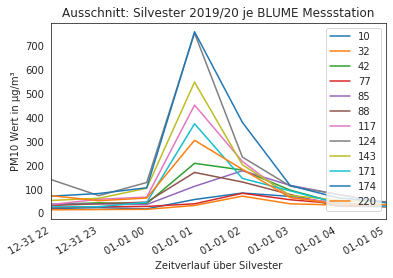

In [144]:
#BLUME related: Careful adjuste the dates! BLUME publishes the hourly mean for 13:00 - 14:00 as 14:00
end_nye = pd.Timestamp(2020, 1, 1, 5)
end_nye = pd.Timestamp(end_nye,  tz='CET')
start_nye = pd.Timestamp(end_nye - timedelta(hours=7))
mask_nye = (df_global.index >= start_nye) & (df_global.index <= end_nye)
blume_nye_exception = df_global.loc[mask_nye]

blume_nye_exception.plot()

#Place labels
plt.xlabel('Zeitverlauf über Silvester') 
plt.ylabel('PM10 Wert in µg/m³')

plt.title("Ausschnitt: Silvester 2019/20 je BLUME Messstation")

plt.legend()

plt.show()


Erkentniss: Eine Fixe Größe, bzw. ein absoluter Wert, bei dem PM10 Werte gedeckelt werden können, existiert nicht. Es muss eine dynamische Ausreisererkennung genutzt werden, die nur auf extreme Werte reagiert. Betrachtet man die Silvester Werte, so erscheint das schwierig. Wie soll der Algorithmus diese Spitzen von den im vorherigen Abschnitt gezeignet Spitzen an einem normalen Tag unterscheiden können, die ja vermeintliche Ausreiser sind?

### Betrachtung aller Maximalwerte
Um das Ausmaß der Ausreiser besser Einordnen zu können, betrachten wir alle Außreiser aller Stationen.

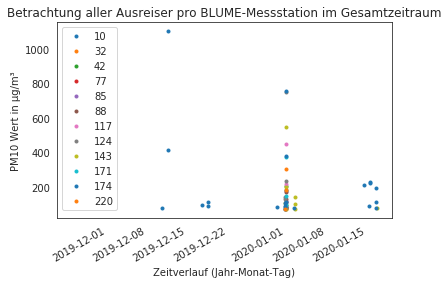

In [147]:
blume_ausreiser_total = df_global[df_global > 70]

blume_ausreiser_total.plot(style=".")

#Place labels
plt.xlabel('Zeitverlauf (Jahr-Monat-Tag)') 
plt.ylabel('PM10 Wert in µg/m³')

plt.title("Betrachtung aller Ausreiser pro BLUME-Messstation im Gesamtzeitraum")

plt.legend()

plt.show()

Erkentniss: Abseits von Silvester, hat nur die Station 174 regelmäßige Ausreißer mit Werten über 70. Es ist weiterhin unklar, was am 2019-12-11 passierte, dass die Werte so abheben. Vermutlich ist es am besten, die Werte überhaupt nicht zu korrigieren, da hier ersichtlich ist, dass es so wenige Werte sind die überhaupt nicht schwer ins Gewicht fallen. Vielleicht kann zu einem späteren Zeitpunkt noch eine bessere Aussage getroffen werden, was genau am 2019-12-11 an der Station 174 passierte.

## OSeM: Entferne Außreiser
Aufgrund der hohen Zeitlichen Auflösung der OSeM Daten, fallen Außreiser weniger ins Gewicht. Da die Daten aber nicht schon vorab auf Stundenwerte gemittelt wurden wie bei BLUME-Messwerten, können Außreiser anhand der Nachbar-Messwerte leicht identifiziert werden. Das macht insbesondere deswegen Sinn, weil davon ausgegangen wird dass OSeM Messgeräte nicht dieselbe Präzision in der Bedienung erfahren wie die von BLUME. Kurze Ausreißer können z.B. davon kommen, dass eine Person vom Nachbarbalkon Zigarettenrauch in den Sensor bläßt.
Nachdem alle Außreiser von einem Sensor elimiert wurden, kann auch noch geprüft werden ob ein Sensor insgesamt Falsche Werte liefert. Wenn dieser z.B. im Betrachtungszeitraum im Median < 1 misst, kann dieser gefiltert werden. Hier muss aber besonders vorsichtig gefiltert werden, denn wenn z.B. eine Hintergrund- oder Waldstation insgesamt einen Median < 3 liefert, kann das durchaus realistisch.

### Lokale Ausreiser in den Zeitserien entfernen
Zwei bekannte Methoden zum Entfernen von Ausreißern sind: IQR Score und Z-Score. Beide nehmen den Datensatz als ganzes und entfernen dann anhand von Mittelwerten oder Quantillen. Das Problem dabei ist, dass die hohe zeitliche Auflösung manchmal für Ausreiser sorgt, die unter bezugnahme des gesamtheitlichen Mittels keinen Ausreiser darstellen. Wenn man jedoch nur die Umgebenden Werte betrachtet, ist der Ausreißer erkennbar. Zum Beispiel:

In [150]:
final_df.iloc[:, 4]

2019-12-11 00:00:00.304000+01:00   NaN
2019-12-11 00:00:01.165000+01:00   NaN
2019-12-11 00:00:01.712000+01:00   NaN
2019-12-11 00:00:02.023000+01:00   NaN
2019-12-11 00:00:04.763000+01:00   NaN
                                    ..
2019-12-11 23:59:50.082000+01:00   NaN
2019-12-11 23:59:52.530000+01:00   NaN
2019-12-11 23:59:54.774000+01:00   NaN
2019-12-11 23:59:56.851000+01:00   NaN
2019-12-11 23:59:57.239000+01:00   NaN
Name: 594c01c7be77820011792181_PM10, Length: 63708, dtype: float64

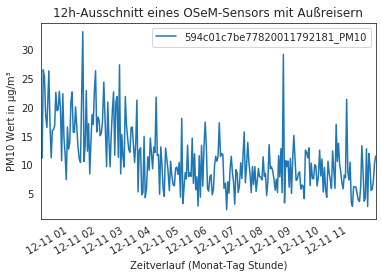

In [151]:
end_test_outliers = pd.Timestamp(2019, 12, 11, 12)
end_test_outliers = pd.Timestamp(end_test_outliers,  tz='CET')
start_test_outliers = pd.Timestamp(end_test_outliers - timedelta(hours=12))
#Picking a random example of a sensor to look for a outlier
test_outliers = final_df.iloc[:, 4].dropna()
test_outliers_timeslot = test_outliers[(test_outliers.index >= start_test_outliers) & (test_outliers.index <= end_test_outliers)]

test_outliers_timeslot.plot()
#Place labels
plt.xlabel('Zeitverlauf (Monat-Tag Stunde)') 
plt.ylabel('PM10 Wert in µg/m³')

plt.title("12h-Ausschnitt eines OSeM-Sensors mit Außreisern")

plt.legend()

plt.show()

### Hampel-Filter
Für die Erkennung von Ausreisern einer Zeitserie ist der Hampel-Filter geeignet. Ein sehr guter Artikel, der das weitere Vorgehen beschreibt und aus dem die folgenden Code-Abschnitte stammen ist dieser hier: https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d

Es gibt zwei Einstellbare Variablen:
- Größe des Sliding Windows
- Anzahl an Standardabweichungen welche den Ausreiser identifizieren

In [152]:
def hampel_filter_demo(input_series, window_size=10, n_sigmas=3):

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    rolling_median = input_series.rolling(window=2*window_size, center=True).median()
    rolling_mad = k * input_series.rolling(window=2*window_size, center=True).apply(MAD)
    diff = np.abs(input_series - rolling_median)

    indices = list(np.argwhere(diff > (n_sigmas * rolling_mad)).flatten())
    
    #Either Replace with NaN or with the Surrounding Median
    new_series[indices] = np.NaN
    #new_series[indices] = rolling_median[indices]
    
    return new_series, indices

Nun werden die Parameter eingestellt und die Outlier grafisch dargestellt

In [153]:
res, detected_outliers = hampel_filter_demo(test_outliers_timeslot, window_size=10, n_sigmas=3)

/home/konstantin/.virtualenvs/Python_BA/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  # Remove the CWD from sys.path while we load stuff.
/home/konstantin/.virtualenvs/Python_BA/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


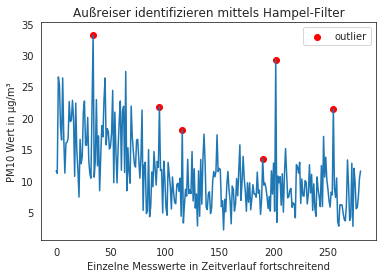

In [160]:
plt.plot(np.arange(len(test_outliers_timeslot)), test_outliers_timeslot)
plt.scatter(detected_outliers, test_outliers_timeslot[detected_outliers], c='r', label='outlier')
plt.title('Außreiser identifizieren mittels Hampel-Filter')
plt.xlabel('Einzelne Messwerte in Zeitverlauf fortschreitend')
plt.ylabel('PM10 Wert in µg/m³')
plt.legend()
plt.show()

Als nächstes werden die Outlier entfernt. Es bestünde auch die Möglichkeit, Sie durch Mittelwerte zu ersetzen, aber das würde den Mittelwert stärker gewichten. Die Roten Punkte sind jetzt an leeren Stellen, wo früher die Outlier lagen.

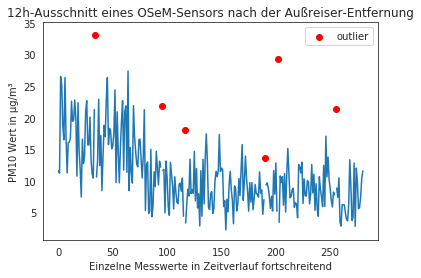

In [157]:
plt.plot(np.arange(len(res)), res)
plt.scatter(detected_outliers, test_outliers_timeslot[detected_outliers], c='r', label='outlier')
plt.xlabel('Einzelne Messwerte in Zeitverlauf fortschreitend')
plt.ylabel('PM10 Wert in µg/m³')

plt.title("12h-Ausschnitt eines OSeM-Sensors nach der Außreiser-Entfernung")
plt.legend();
plt.show()

Entferne alle Outlier aus dem kompletten Datenbestand. Dazu wird die Funktion leicht umgeschrieben, da hier jetzt keine Visualisierung mehr nötig ist. Außerdem werden die NAN Werte kurzfristig entfernt, damit die Berechnung performanter ist.

In [158]:
def hampel_filter_apply(input_series, window_size=10, n_sigmas=3):

    input_series.dropna(inplace=True)
    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    rolling_median = input_series.rolling(window=2*window_size, center=True).median()
    rolling_mad = k * input_series.rolling(window=2*window_size, center=True).apply(MAD)
    diff = np.abs(input_series - rolling_median)

    indices = list(np.argwhere(diff > (n_sigmas * rolling_mad)).flatten())
    new_series[indices] = rolling_median[indices]
    
    return new_series

In [159]:
final_df_outliers = final_df.iloc[:,:].apply(hampel_filter_apply)

/home/konstantin/.virtualenvs/Python_BA/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  # This is added back by InteractiveShellApp.init_path()


Indem man die Messpunkte aus dem Finalen Datensatz mit den entfernten Outliers über die des Auschnittes aus dem Vorherigen Test legt, kann man Prüfen, ob man richtig entfernt hat.

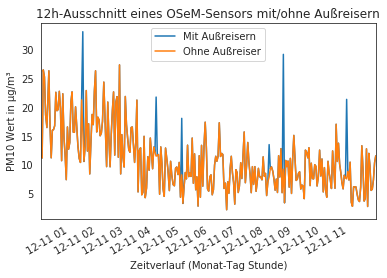

In [162]:
#Picking the same random example of a sensor to look for a outlier that we took earlier
test_outliers_again = final_df_outliers.iloc[:, 4].dropna()
test_outliers_again_timeslot = test_outliers_again[(test_outliers_again.index >= start_test_outliers) & (test_outliers_again.index <= end_test_outliers)]

plot_df = pd.concat([test_outliers_timeslot, test_outliers_again_timeslot], axis=1, sort=False)
plot_df.columns = ['Mit Außreisern', 'Ohne Außreiser']

plot_df.plot()
# set labels for both axes
plt.xlabel('Zeitverlauf (Monat-Tag Stunde)') 
plt.ylabel('PM10 Wert in µg/m³')

plt.title("12h-Ausschnitt eines OSeM-Sensors mit/ohne Außreisern")
plt.legend();
plt.show()

Erkentnis: Auch bei der globalen Bereinigung des Datensatzes wurden die Ausreiser sauber entfernt. Es ist also davon auszugehen, dass im gesamten sauber gearbeitet wurde.

### Unzuverlässige Sensoren entfernen
Betrachten wir zunächst die durchschnittlich gemessenen Werte der Sensoren. Zuerst in einem Diagramm, dann in einem Boxplot um die Quantillen zu sehen.

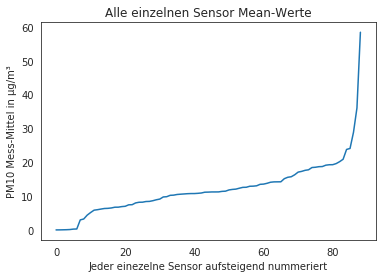

In [163]:
#Using right label because BLUME does the same... Be careful, don't mix up the periods
global_sensor_means = final_df.mean().sort_values(ascending=True)
plt.plot(np.arange(len(global_sensor_means)), global_sensor_means)
plt.xlabel('Jeder einezelne Sensor aufsteigend nummeriert')
plt.ylabel('PM10 Mess-Mittel in µg/m³')
plt.title('Alle einzelnen Sensor Mean-Werte')
plt.show()

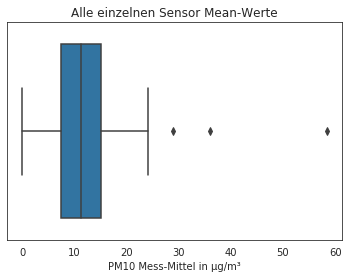

In [164]:
ax = sns.boxplot(x=global_sensor_means)
plt.xlabel("PM10 Mess-Mittel in µg/m³")
plt.title("Alle einzelnen Sensor Mean-Werte")
plt.show()

Erkentnis: Es gibt einen sehr großen Mittelbereich, zwischen ca. 8-16. Es gibt einen Minimum und Maximum Bereich mit Extremwerten um 0 herum bzw. ab 20 Aufwärts. Nachfolgend werden die oberen und unteren Extram der Sensorwerte betrachtet um ein Muster zu finden.

/home/konstantin/.virtualenvs/Python_BA/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


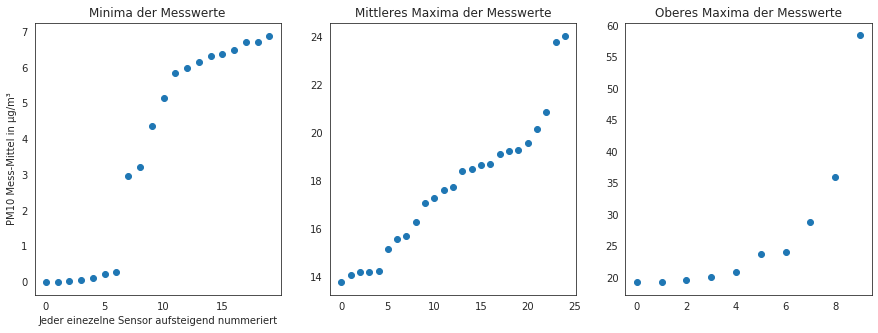

In [165]:
# Creates two subplots and unpacks the output array immediately
extreme_tail_plot = global_sensor_means.tail(10)
tail_plot = global_sensor_means[global_sensor_means < 25].tail(25)
head_plot = global_sensor_means.head(20)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
#Plot Lower Bounds
ax1.scatter(np.arange(len(head_plot.index)), head_plot.values)
ax1.set_xlabel('Jeder einezelne Sensor aufsteigend nummeriert')
ax1.set_ylabel('PM10 Mess-Mittel in µg/m³')
ax1.set_title('Minima der Messwerte')
#Plot Middle-High Bounds
ax2.scatter(np.arange(len(tail_plot.index)), tail_plot.values)
ax2.set_title('Mittleres Maxima der Messwerte')

#Plot Extreme-High Bounds
ax3.scatter(np.arange(len(extreme_tail_plot.index)), extreme_tail_plot.values)
ax3.set_title('Oberes Maxima der Messwerte')

f.show()

##### Interpretation
- Auf Abb1. ist deutlich zu sehen, dass es 7 Messstationen gibt an denen stark unterdurchschnittliche Werte gemessen werden. Nachbarmesswerte fangen erst ab dem ca. dreifachen Eigenwert an und so kann bei einer konservativen Einschätzung davon ausgegangen werden, dass Messtationen unter 2 fehlerhaft sind.
- Auf Abb2. und Abb3 ist zu sehen, dass es bis 25 oder 30 eine relativ breite Verteilung an Messwerten gibt, deren Muster plausibel wirken. Sicherlich kann der oberste Punkt bei knapp 60 als Unzuverlässig eingestuft werden. Alle Punkte darunter sind jedoch bei einer konservativen Interpretation nicht eindeutig als Ausreißer zu erkennen.
- Für die weiteren Berechnungen werden nur die Sensoren im Bereich 2 < x < 40 Berücksichtig.

Im Nachfolgenden Schritt werden die Extremwerte entfernt

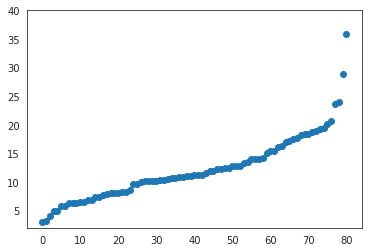

In [166]:
#Create and apply a Mask to Remove those Sensors, that measure invalid
clean_extremas = global_sensor_means[(global_sensor_means > 2) & (global_sensor_means < 40)]
final_df_outliers_extrema = final_df_outliers[clean_extremas.index]

#Calculate the Means to depict and verify the results
final_df_outliers_extrema_means = final_df_outliers_extrema.mean().sort_values(ascending=True)
plt.scatter(np.arange(len(final_df_outliers_extrema_means)), final_df_outliers_extrema_means)
plt.ylim(2,40)
plt.show()

## Rekapitulation des Kapitels Daten - Aufbereitung
- Zunächst wurden die aktuellen Daten von BLUME und OSeM eingeladen.
- Anhand eines simplen Stundenmittelwert wurden die Daten erstmals verglichen
- Anhand eines Stundenmittelwert Vergleichs über 24h wurden die Daten gegeneinander grafisch verglichen
-- Ausreiser sowohl bei OSeM als auch bei BLUME wurden erkannt
- Ausreiser bei BLUME werden akzeptiert, da die Daten von BLUME als Hochakurat eingestuft werden und lokale Maxima tatsächlich passieren können (Bsp: Silvester). Ein künstlicher Eingriff könnte die Gefahr einer Verunreinigung der Daten erhöhen und ist angesichts der absolut gesehen wenigen Maxima auch nicht nötig
- Ausreiser bei der OSeM werden mittels des Hampel-Filters normalisiert. Anhand eines Beispielhaften Ausschnitts einer Messstation wurden versucht die richtigen Parameter zu finden. Mit diesen wurde dann der ganze Datensatz normalisiert.
- Zudem wurden bei der OSeM Stationen entfernt, die im Durchschnitt deutlich andere Ergebnisse messen, als alle anderen Stationen. Mittels einer Grapishen Analyse wurden Ober- und Untergrenzen definiert welche außerhalb des statistisch erkannten Musters liegen, in dem Stationen üblicherweise Durchschnittswerte liefern.

## Neues Vergleichsmas: Lineare Regression
Grafische Vergleiche und Diagramme helfen Muster zu erkennen und Daten schnell und einfach verstehen und vergleichen zu können. Manche Feinheiten und Ähnlichkeiten in den Daten können aber schneller und gründlicher mit der Linearen Regression erkannt werden. Insbesondere zum Vergleichen der Linearität der Daten von OSeM mit denen von BLUME eignet sich diese Berechnung. Die Daten der BLUME dienen hierbei als die unabhängige und die Daten von OSeM als abhängige Variable. Ein R²-Wert nahe 1 bedeutet, dass sich die Daten sehr ähnlich sind während ein kleiner R²-Wert einen großen Unterschied in den Daten bedeutet.

$$x_{1,2} = {-b\pm\sqrt{b^2 - 4ac} \over 2a}.$$

$$A %  = {-b\pm\sqrt{b^2 - 4ac} \over 2a}.$$

Im folgenden wird der Versuch zum Eingang der Arbeit wiedrholt, an dem der komplette Datensatz eines Tages im Stündlichen Mittel verglichen wird und mittels linearer Regression verglichen. Zuerst werden die Daten vor der Bereinigung verglichen und dann dannach.

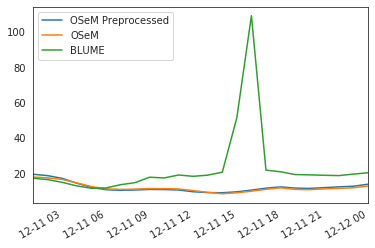

In [168]:
#Using right label because BLUME does the same... Be careful, don't mix up the periods
#Calculate the Hourly Mean for every Sensor seperately
hourly_sensors_preped = final_df_outliers_extrema.resample('60T', label='right').mean()
#Calculate the Hourly Mean of all Sensors Berlin-Wide
hourly_sensors_preped_mean = hourly_sensors_preped.mean(axis=1)
hourly_sensors_preped_mean.name = "OSeM Preprocessed"

#Since we did not alter the BLUME data, we can reuse the one from the beginning
#--hourly_blume_mean = blume_hourly.mean(axis=1)
#--hourly_blume_mean.name="BLUME"

blume_vs_osem_hourly_preped = pd.concat([hourly_sensors_preped_mean, hourly_sensor_mean, hourly_blume_mean], axis=1)
blume_vs_osem_hourly_preped.plot()

/home/konstantin/.virtualenvs/Python_BA/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


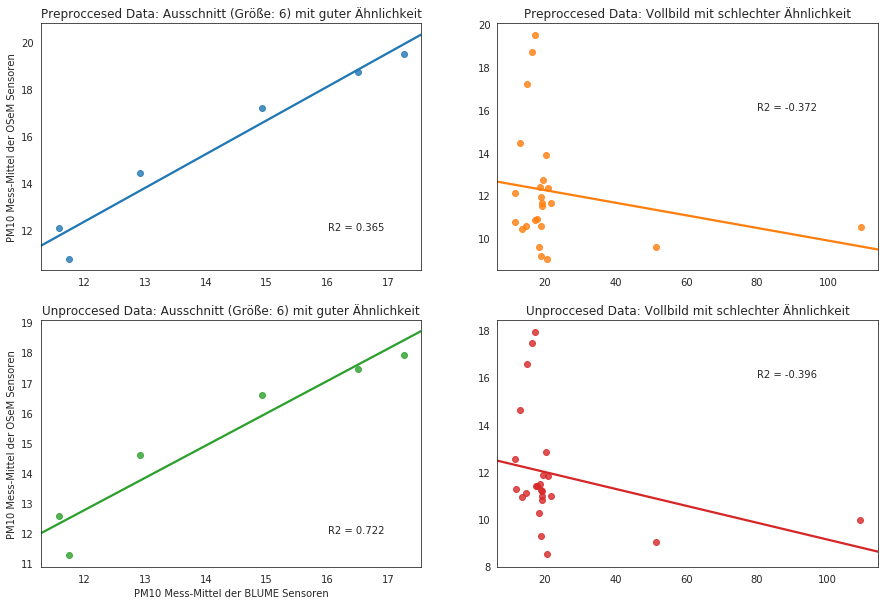

In [184]:
f, ax = plt.subplots(2, 2, figsize=(15,10))
s1=0
s2=6

y_pred = hourly_sensors_preped_mean.values
y_pred_unprocessed = hourly_sensor_mean.values
y_real = hourly_blume_mean.values

#Plot 1: Processed Section with good Fit/R² Value
sns.regplot(y_real[s1:s2], y_pred[s1:s2], ci=None, ax=ax[0,0])
ax[0,0].text(16, 12, 'R2 = %0.3f' % r2_score(y_real[s1:s2], y_pred[s1:s2]))
ax[0,0].set_title('Preproccesed Data: Ausschnitt (Größe: {}) mit guter Ähnlichkeit'.format(s2-s1))
ax[0,0].set_ylabel('PM10 Mess-Mittel der OSeM Sensoren')

#Plot 2: Processed Full Section with pretty bad Fit/R² Value
sns.regplot(y_real, y_pred, ci=None, ax=ax[0,1])
ax[0,1].text(80, 16, 'R2 = %0.3f' % r2_score(y_real, y_pred))
ax[0,1].set_title('Preproccesed Data: Vollbild mit schlechter Ähnlichkeit')

#Change Prediction to Unprocessed Data

#Plot 3: Un-Processed Section with good Fit/R² Value
sns.regplot(y_real[s1:s2], y_pred_unprocessed[s1:s2], ci=None, ax=ax[1,0])
ax[1,0].text(16, 12, 'R2 = %0.3f' % r2_score(y_real[s1:s2], y_pred_unprocessed[s1:s2]))
ax[1,0].set_title('Unproccesed Data: Ausschnitt (Größe: {}) mit guter Ähnlichkeit'.format(s2-s1))
ax[1,0].set_ylabel('PM10 Mess-Mittel der OSeM Sensoren')
ax[1,0].set_xlabel('PM10 Mess-Mittel der BLUME Sensoren')

#Plot 4: Un-Processed  Full Section with pretty bad Fit/R² Value
sns.regplot(y_real, y_pred_unprocessed, ci=None, ax=ax[1,1])
ax[1,1].text(80, 16, 'R2 = %0.3f' % r2_score(y_real, y_pred_unprocessed))
ax[1,1].set_title('Unproccesed Data: Vollbild mit schlechter Ähnlichkeit')


f.show()

Beschreibung: 
- Blau und Gelb sind jeweils die Bereinigten Daten, also ohne Außreiser.
- Grün und Rot sind die rohen Daten, ohne dass die Außreiser entfernt wurden.
- Linke Seite ist jeweils nur ein Ausschnitt (von 0-8 Uhr)
- Rechte Seite ist das Vollbild
- Darstellung als "Actual vs. Fitted Graph": Liegen alle Punkte auf der Diagonalen, so herrscht perfekte Linearität der zu vergleichenden Messwerte (siehe: https://stats.stackexchange.com/questions/104622/what-does-an-actual-vs-fitted-graph-tell-us) 

Erkentniss: 
- Kleiner Ausschnitt aus den Morgenstunden hat jeweils hohen R2 Wert
- Schlechter/Negaitver R2 Wert und somit geringe Linearität bei Betrachtung des Vollbilds (24h)
- Bereinigte Daten ohne Ausreiser machen die Ergebnisse weniger Extrem. Sie verbessern das Ergebniss im Negativen Bereich und verschlechtern es im positiven Bereich.
- Es erscheint auf den ersten Blick nicht hilfreich, die Daten mit der hier dargestellten Methode zu Bereinigen. Sie muss unbedingt überprüft werden (größere Datenmenge, andere Methode).
- Der zeitliche Ausschnitt der Daten ist zu klein um eine fundierte Aussage treffen zu können.